# Training Models:
- **Feature Selection**: We will be doing a step-wise feature selection where we will be feeding the model different subsets of the explanatory variables and selecting the most optimal. 
- **Model Selection** : We will be examining he model with the best accuracy and F1 parameters.
- **Algorithm Selection** : We will be training Logistic Regression, Decision Trees and CatBoost and opting for the best classification algorithm. 

In [2]:
import pandas as pd

data = pd.read_csv('Data/weather_forecast_data.csv')

In the EDA section we observed that the number of observations for 'rain' are far less than those from 'no rain'
- num of rain observations: 314
- num of no rain observations: 2186

Thats only 14% of the observations giving information about rain.


The location of where the data was collected is of important knowledge to see if the data that we posses is representative of a real-life scenario. But we dont have that information.  Lets proceed to split the data into testing and training. 

We will opt for a stratifiedsplit to keep the same proportions of rain to no rain obs equally, to not incur in **sampling bias**. 

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

def split_and_correct(data, yvarname):
    split = StratifiedShuffleSplit(n_splits =1, test_size = 0.2, random_state = 30)
    data['Rain'] = data[yvarname].map({'rain': 1,'no rain': 0})
    for itrain, itest in split.split(data, data[yvarname]):
        XTrain = data.loc[itrain]
        XTest = data.loc[itest]
        Y_Train = XTrain[yvarname]
        X_Train = XTrain.drop(yvarname, axis = 1)
        Y_Test = XTest[yvarname]
        X_Test = XTest.drop(yvarname, axis = 1)
        
    return X_Test, X_Train, Y_Test, Y_Train

In [4]:
XTest, XTrain, ytest, ytrain = split_and_correct(data, 'Rain')

In [5]:
XTest.shape

(500, 5)

In [6]:
XTrain.shape

(2000, 5)

In [7]:
sum(ytest == 1) / sum(ytest == 0)

0.14416475972540047

In [8]:
sum(ytrain == 1) / sum(ytrain == 0)

0.14351057747284163

# Standarize the data

In [9]:
from sklearn.preprocessing import StandardScaler
standarizer = StandardScaler()
XTrain1 = standarizer.fit_transform(XTrain)
XTest1 = standarizer.fit_transform(XTest)

## Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
#model with all variables
log_reg.fit(XTrain1, ytrain)
log_reg.coef_

array([[-1.77951601,  2.54944472, -0.08486666,  2.26601776,  0.04176596]])

In [11]:
Coef = pd.DataFrame(log_reg.coef_, columns = data.columns[:-1])
Coef

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure
0,-1.779516,2.549445,-0.084867,2.266018,0.041766


In [12]:
from sklearn.metrics import accuracy_score
y_pred = log_reg.predict(XTest1)
acc = accuracy_score(ytest, y_pred)

In [13]:
acc

0.928

Since sklearn doesnt have a stepwise feature selection process we will use the RFE (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) 


In [14]:
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
selector = RFE(log_reg, n_features_to_select=3, step=1)
selector = selector.fit(XTrain, ytrain)

In [15]:
features =data.columns[:-1]
modelf = features[selector.support_]
modelf

Index(['Temperature', 'Humidity', 'Cloud_Cover'], dtype='object')

In [16]:
XTrain2 = standarizer.fit_transform(XTrain[modelf])
XTest2 = standarizer.fit_transform(XTest[modelf])

lets fit the model **Rain = b0 + Temperature + Humidity + Cloud_Cover** with those variables and calculate the accuracy 

`.predict()` predicts classes and `.predict_proba` outputs the probability calculations 

In [17]:
log_reg2 = LogisticRegression()
#model with all variables
log_reg2.fit(XTrain2, ytrain)

ypred_train = log_reg2.predict(XTrain2)
#Fit model 2 for testing data
y_pred2 = log_reg2.predict(XTest2)
print(f'Accuracy on Test Data is : {accuracy_score(ytest, y_pred2)}')
print(f'Accuracy on Training Data is: {accuracy_score(ytrain, ypred_train)}')

Accuracy on Test Data is : 0.93
Accuracy on Training Data is: 0.932


### Coefficients of Logistic Regression

In [18]:
import numpy as np
print('coefficients for model Temp + Humidity + Cloud Cover')
print(np.exp(log_reg2.coef_)) #Calculate odd ratios

coefficients for model Temp + Humidity + Cloud Cover
[[ 0.16896571 12.69791973  9.64665321]]


## Explain the coefficients, how to calculate the 95% C.I ?
Pending


### Classification Performance Metrics 

In [19]:
def output_classmetrics(ypred, ytrue):
    from sklearn.metrics import confusion_matrix
    # Confusion matrix for the test model
    cm = pd.DataFrame(confusion_matrix(ytest, ypred), columns = ['Neg Pred', 'Pos Pred'], index = ['Neg Actual', 'Pos Actual'])
    print(cm)
    print("\n")

    from sklearn.metrics import precision_score, recall_score
    print(f' Precision score: {round(precision_score(ytrue, ypred),2)}')
    print(f' Recall score: {round(recall_score(ytrue, ypred),2)}')

In [20]:
output_classmetrics(y_pred2, ytest)

            Neg Pred  Pos Pred
Neg Actual       425        12
Pos Actual        23        40


 Precision score: 0.77
 Recall score: 0.63


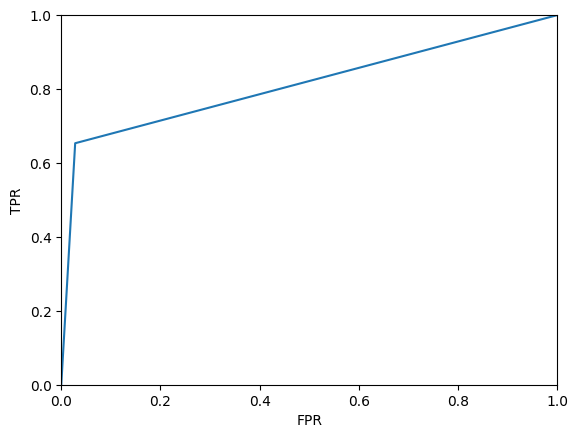

In [24]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(ytrain,ypred_train)

def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, label = label)
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [25]:
print(roc_auc_score(ytrain, ypred_train))

0.812685222517591


Lets try the Stochastic Gradient Descent Classifier on the data modeled with Temp, Humidity ad Cloud Cover which where the variables observed with greater importance. 

## SGD : Stochastic Gradient Descent Classifier by default applies a SVM.

In [26]:
from sklearn.linear_model import SGDClassifier

r = 42 #random state
sdg = SGDClassifier(random_state = r)
sdg.fit(XTrain2, ytrain)
ypred = sdg.predict(XTest2)

from sklearn.metrics import accuracy_score, roc_auc_score
accuracy_score(ytest, ypred)

0.93

In [27]:
from sklearn.ensemble import RandomForestClassifier


for depth in range(3,6,1):
    forest = RandomForestClassifier(n_estimators = 50, 
                                    max_depth = depth,
                                    min_samples_split = 20,
                                    random_state = r,
                                    bootstrap = True)

    #fit model to the training data
    forest.fit(XTrain2, ytrain)
    ypred_Trainforest = forest.predict(XTrain2)
    ypred_forest = forest.predict(XTest2)

    model = forest.__class__.__name__
    print('Testing accuracy for %s with depth %s is %s' % (model,  
                                                         str(depth), 
                                                         accuracy_score(ytest, ypred_forest)))


Testing accuracy for RandomForestClassifier with depth 3 is 0.988
Testing accuracy for RandomForestClassifier with depth 4 is 0.99
Testing accuracy for RandomForestClassifier with depth 5 is 0.99


## Save standarized splitted data

In [63]:
pd.concat([XTest, ytest], axis = 1).to_csv('Data/WeatherTestingData.csv', header = True, index = True)
pd.concat([XTrain, ytrain], axis = 1).to_csv('Data/WeatherTrainingData.csv', header = True, index = True)

In [44]:
!ls

Data                 ModelSelection.ipynb
EDA.ipynb            READ.ME
